# **一个VQVAE算法的简单实现**
## **算法概述**
- 传统的VAE算法将数据编码为高斯分布
- 利用向量量化（vector quantisation）对数据进行编码
- 

论文链接：*https://arxiv.org/abs/1711.00937*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torch.optim as optim

device = 0 if torch.cuda.is_available else "cpu"
dataset_name = "mnist"

In [2]:
class VectorQuantizer(nn.Module):
    
    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        
    def forward(self, z):
        """
            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W, C)
        """
        z = z.permute(0,2,3,1).contiguous()
        z_flattened = z.view(-1, self.e_dim)  # C == self.e_dim ???
        
        # cal the dis between each emb in z_flattened and emb in embedding
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight ** 2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t()) # norm l2 squared
        
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1) # B * H * W, 1  most similarity for every z in vq, p(z|x)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device) # B* H * W, n
        min_encodings.scatter_(1, min_encoding_indices, 1)
        
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape) # A x K * K x D 每个像素对应了一个D -> BHWC
        
        # compute loss
        loss = torch.mean((z_q - z.detach())**2) + self.beta * torch.mean((z_q.detach() - z)**2) # 第一项保证了编码表的准确性？第二项让模型输出的编码向编码表集中，防止编码表变来变去。
        
        # unknown
        z_q = z + (z_q - z).detach()
        
        # perplexity
        e_mean = torch.mean(min_encodings, dim=0) # the frequency of each n_emb
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))   # entropy？e^H(p)表示困惑度，困惑度越低表示模型的预测结果与样本越契合
        
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        
        return loss, z_q, perplexity, min_encodings, min_encoding_indices
        

In [3]:
class ResidualLayer(nn.Module):
    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1, stride=1, bias=False)
        )
        
    def forward(self, x):
        x = x + self.res_block(x)
        return x

class ResidualStack(nn.Module):
    
    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)] * n_res_layers)
        
    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers)
        )
        
    def forward(self, x):
        return self.conv_stack(x)
    
class Decoder(nn.Module):
    
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2
        
        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim // 2, 1, kernel_size=kernel, stride=stride, padding=1)
        )
        
    def forward(self, x):
        x = self.inverse_conv_stack(x)
        return x

In [5]:
class VQVAE(nn.Module):
    
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()        
        self.encoder = Encoder(1, h_dim,n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(h_dim, embedding_dim, kernel_size=1, stride=1) # n_embeddings is a large num usually
        self.vector_quantization = VectorQuantizer(n_embeddings, embedding_dim, beta)
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)
        
        self.h_c = 512
        self.h_w = 8
        self.h_h = 8
        
    def forward(self, x, verbose=False):
        z_e = self.encoder(x)
        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)
        
        return embedding_loss, x_hat, perplexity
    
    @torch.no_grad()
    def sample(self, num_samples): # 貌似这种随机index 的采样方法不能正常生成数据，需要训练一个pixelCNN网络
        n_e = self.vector_quantization.n_e
        e_dim = self.vector_quantization.e_dim
        
        sample_idx = torch.randint(*(0, n_e), (num_samples * 64, 1)).to(device)
        sample_emb = torch.zeros(sample_idx.shape[0], n_e).to(device)
        sample_emb.scatter_(1, sample_idx, 1)
        z_q = torch.matmul(sample_emb, self.vector_quantization.embedding.weight.detach()).view(num_samples,8,8,512).contiguous()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return self.decoder(z_q).cpu().numpy()
        

In [6]:
from datasets import load_dataset
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

batch_size_train = 32
dataset = load_dataset(dataset_name)
transform = Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t:(t*2) - 1)
])



def transforms_(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms_).remove_columns("label")

dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size_train, shuffle=True)

In [7]:
%%capture
# init model
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
n_embeddings = 64
embedding_dim = 512
beta = 0.25

learning_rate = 1e-3

model = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers, n_embeddings, embedding_dim, beta)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
model.to(device)

In [8]:
def train(epoch):
    model.train()
    
    batch_count = 0
    loss_sum_in_one_batch = 0
    recon_loss_sum_in_one_batch = 0
    embedding_loss_sum_in_one_batch = 0
    # for epoch in range(epochs):
    for batch_idx, batch in enumerate(dataloader):
        data = batch["pixel_values"].to(device)

        embedding_loss, x_hat, perplexity = model(data)
        recon_loss = F.mse_loss(x_hat, data)
        loss = embedding_loss + recon_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum_in_one_batch += loss.item()
        recon_loss_sum_in_one_batch += recon_loss.item()
        embedding_loss_sum_in_one_batch += embedding_loss.item()
        batch_count += 1
        if batch_count % 100 == 0:
            print(f"epoch {epoch} batch count {batch_count} , avg loss is {loss_sum_in_one_batch / batch_count}, \
            recon loss is {recon_loss_sum_in_one_batch / batch_count}, \
            emb loss is {embedding_loss_sum_in_one_batch / batch_count}")
            # generate_image(x_hat.detach().cpu().numpy())
            


In [9]:
import matplotlib.pyplot as plt
def generate_image(images):
    image = images[0,0,:,:]
    plt.imshow(image, cmap='gray')
    plt.show()

epoch 1 batch count 100 , avg loss is 4.857141825407743,             recon loss is 0.3207667729258537,             emb loss is 4.536375034486409
epoch 1 batch count 200 , avg loss is 3.65606976762414,             recon loss is 0.22119475301355124,             emb loss is 3.434875003044726
epoch 1 batch count 300 , avg loss is 3.457688946624597,             recon loss is 0.1736081742371122,             emb loss is 3.284080762031954
epoch 1 batch count 400 , avg loss is 2.7574944000691177,             recon loss is 0.14416568879969419,             emb loss is 2.6133287039125572
epoch 1 batch count 500 , avg loss is 2.2842046726047993,             recon loss is 0.12454356681555509,             emb loss is 2.1596610999186523
epoch 1 batch count 600 , avg loss is 1.9409290036807458,             recon loss is 0.110221845159928,             emb loss is 1.8307071536845372
epoch 1 batch count 700 , avg loss is 1.6847676319522518,             recon loss is 0.09914790419861674,             emb lo

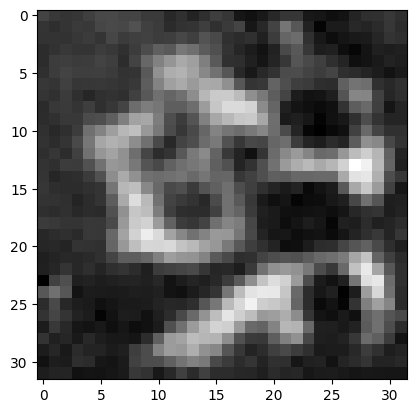

epoch 2 batch count 100 , avg loss is 0.04034967608749866,             recon loss is 0.01452803566120565,             emb loss is 0.025821640528738497
epoch 2 batch count 200 , avg loss is 0.03961198914796114,             recon loss is 0.014383714119903744,             emb loss is 0.025228275069966912
epoch 2 batch count 300 , avg loss is 0.03866755170747638,             recon loss is 0.014139646071319779,             emb loss is 0.024527905670305092
epoch 2 batch count 400 , avg loss is 0.03785281869117171,             recon loss is 0.013922701966948807,             emb loss is 0.023930116752162577
epoch 2 batch count 500 , avg loss is 0.03719990551844239,             recon loss is 0.01376213838532567,             emb loss is 0.023437767181545496
epoch 2 batch count 600 , avg loss is 0.0364817468325297,             recon loss is 0.013558463635854423,             emb loss is 0.022923283257211248
epoch 2 batch count 700 , avg loss is 0.03585279213796769,             recon loss is 0.0134

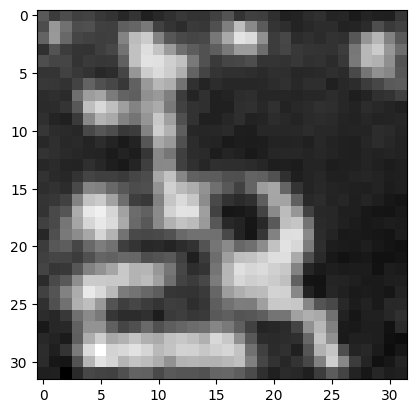

epoch 3 batch count 100 , avg loss is 0.023663202505558728,             recon loss is 0.009772885898128152,             emb loss is 0.013890316588804125
epoch 3 batch count 200 , avg loss is 0.023592459177598356,             recon loss is 0.009768778011202812,             emb loss is 0.013823681119829416
epoch 3 batch count 300 , avg loss is 0.02338711534316341,             recon loss is 0.009708319742543003,             emb loss is 0.01367879556491971
epoch 3 batch count 400 , avg loss is 0.023252250854857267,             recon loss is 0.00965606797602959,             emb loss is 0.013596182861365378
epoch 3 batch count 500 , avg loss is 0.023069267697632314,             recon loss is 0.009596927138976754,             emb loss is 0.013472340555861592
epoch 3 batch count 600 , avg loss is 0.02291419657568137,             recon loss is 0.009537654164402436,             emb loss is 0.013376542399637401
epoch 3 batch count 700 , avg loss is 0.022750718811792987,             recon loss is 

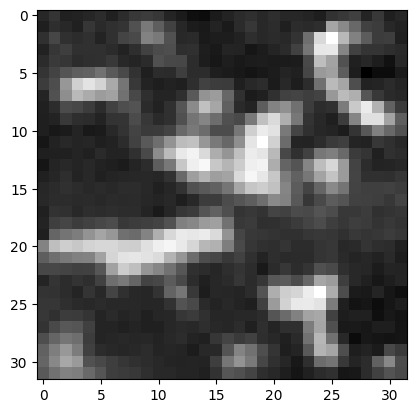

epoch 4 batch count 100 , avg loss is 0.019755665715783834,             recon loss is 0.008311548684723676,             emb loss is 0.011444116942584515
epoch 4 batch count 200 , avg loss is 0.019697775393724443,             recon loss is 0.008271896929945797,             emb loss is 0.011425878400914372
epoch 4 batch count 300 , avg loss is 0.019683449392517406,             recon loss is 0.008265409722613791,             emb loss is 0.011418039659038186
epoch 4 batch count 400 , avg loss is 0.019584711217321457,             recon loss is 0.00820154711487703,             emb loss is 0.011383164073340595
epoch 4 batch count 500 , avg loss is 0.019564368158578874,             recon loss is 0.008194031393155455,             emb loss is 0.011370336724445224
epoch 4 batch count 600 , avg loss is 0.019478335153932373,             recon loss is 0.008143830428210397,             emb loss is 0.011334504686916868
epoch 4 batch count 700 , avg loss is 0.01942794920344438,             recon loss i

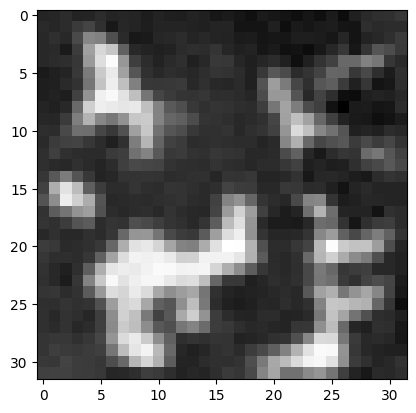

epoch 5 batch count 100 , avg loss is 0.018633225690573452,             recon loss is 0.00754811895545572,             emb loss is 0.011085106711834668
epoch 5 batch count 200 , avg loss is 0.018566664131358265,             recon loss is 0.007531465566717088,             emb loss is 0.0110351985367015
epoch 5 batch count 300 , avg loss is 0.0185076760686934,             recon loss is 0.007499140993071099,             emb loss is 0.011008535049234828
epoch 5 batch count 400 , avg loss is 0.018503124224953354,             recon loss is 0.00750126687460579,             emb loss is 0.011001857328228653
epoch 5 batch count 500 , avg loss is 0.018479615725576878,             recon loss is 0.007483302715234458,             emb loss is 0.010996313001960516
epoch 5 batch count 600 , avg loss is 0.01844104059661428,             recon loss is 0.007453277752889941,             emb loss is 0.010987762832082809
epoch 5 batch count 700 , avg loss is 0.01840275790808456,             recon loss is 0.00

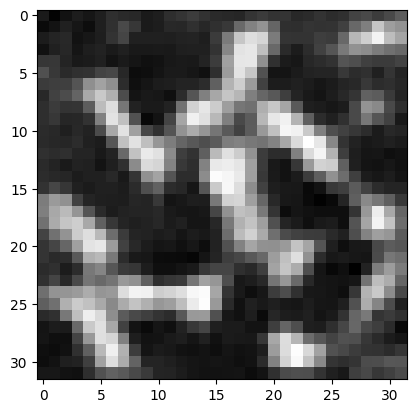

epoch 6 batch count 100 , avg loss is 0.01789397543296218,             recon loss is 0.007032814477570355,             emb loss is 0.010861161043867468
epoch 6 batch count 200 , avg loss is 0.017840342121198772,             recon loss is 0.007018651131074876,             emb loss is 0.010821691071614624
epoch 6 batch count 300 , avg loss is 0.017842516445865233,             recon loss is 0.007028716546483338,             emb loss is 0.010813799987857541
epoch 6 batch count 400 , avg loss is 0.017817439700011165,             recon loss is 0.007007305774604902,             emb loss is 0.010810133991762996
epoch 6 batch count 500 , avg loss is 0.017815376779064536,             recon loss is 0.006999028169550002,             emb loss is 0.010816348668187857
epoch 6 batch count 600 , avg loss is 0.017815088165613512,             recon loss is 0.006994649504777044,             emb loss is 0.010820438698865474
epoch 6 batch count 700 , avg loss is 0.01780796784109303,             recon loss i

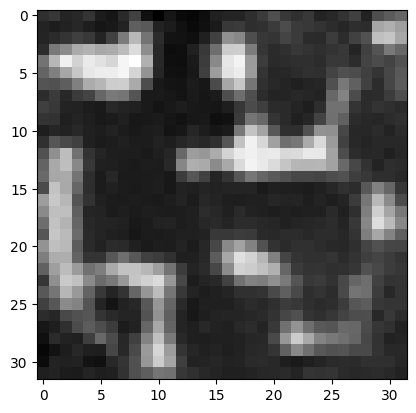

epoch 7 batch count 100 , avg loss is 0.017157906647771597,             recon loss is 0.006584872459061444,             emb loss is 0.010573034174740314
epoch 7 batch count 200 , avg loss is 0.0173453304823488,             recon loss is 0.0066913314070552584,             emb loss is 0.010653999103233218
epoch 7 batch count 300 , avg loss is 0.01735250708957513,             recon loss is 0.006689947003809114,             emb loss is 0.010662560130779942
epoch 7 batch count 400 , avg loss is 0.017381787921767682,             recon loss is 0.006705402776133269,             emb loss is 0.010676385189872234
epoch 7 batch count 500 , avg loss is 0.017373099191114308,             recon loss is 0.0066966217365115885,             emb loss is 0.010676477508619428
epoch 7 batch count 600 , avg loss is 0.017355074152971307,             recon loss is 0.006684342833080639,             emb loss is 0.01067073134550204
epoch 7 batch count 700 , avg loss is 0.01735065150340753,             recon loss is

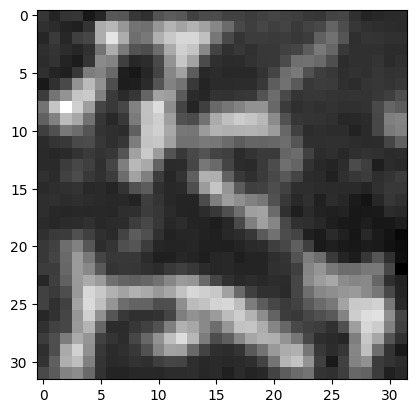

epoch 8 batch count 100 , avg loss is 0.017172777159139514,             recon loss is 0.006531520215794444,             emb loss is 0.010641256915405392
epoch 8 batch count 200 , avg loss is 0.017081937682814897,             recon loss is 0.006492810749914497,             emb loss is 0.010589126958511769
epoch 8 batch count 300 , avg loss is 0.017069633280237514,             recon loss is 0.006473148724374672,             emb loss is 0.010596484582250317
epoch 8 batch count 400 , avg loss is 0.01701640957035124,             recon loss is 0.006448412276804447,             emb loss is 0.010567997293546795
epoch 8 batch count 500 , avg loss is 0.01700790545530617,             recon loss is 0.006442252527922392,             emb loss is 0.010565652936697006
epoch 8 batch count 600 , avg loss is 0.01699421729426831,             recon loss is 0.006435135972375671,             emb loss is 0.010559081346727908
epoch 8 batch count 700 , avg loss is 0.016989710880443452,             recon loss is

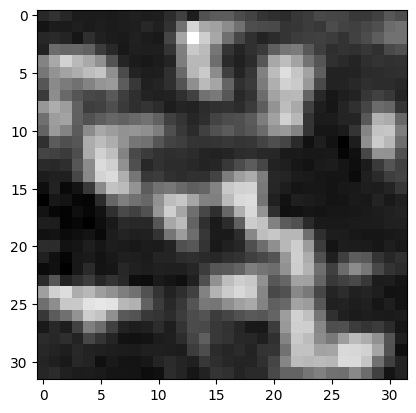

epoch 9 batch count 100 , avg loss is 0.016705483263358474,             recon loss is 0.0061996950395405296,             emb loss is 0.01050578816793859
epoch 9 batch count 200 , avg loss is 0.01668437392450869,             recon loss is 0.006197664109058678,             emb loss is 0.010486709754914045
epoch 9 batch count 300 , avg loss is 0.016679197087263068,             recon loss is 0.0062011728653063375,             emb loss is 0.010478024147450924
epoch 9 batch count 400 , avg loss is 0.01666800174396485,             recon loss is 0.00619475060608238,             emb loss is 0.010473251082003117
epoch 9 batch count 500 , avg loss is 0.016683058701455592,             recon loss is 0.006195454579778016,             emb loss is 0.010487604076042772
epoch 9 batch count 600 , avg loss is 0.01667641366831958,             recon loss is 0.006194729583027462,             emb loss is 0.010481684065113465
epoch 9 batch count 700 , avg loss is 0.016661177815071173,             recon loss is

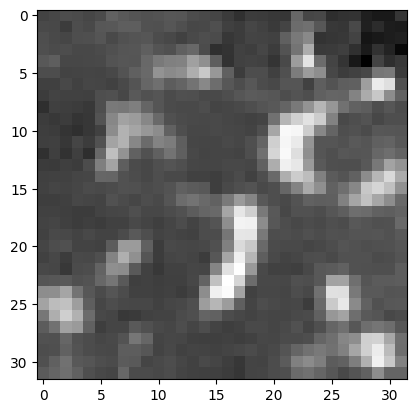

epoch 10 batch count 100 , avg loss is 0.016629670951515435,             recon loss is 0.006025991318747401,             emb loss is 0.010603679735213518
epoch 10 batch count 200 , avg loss is 0.016579765300266443,             recon loss is 0.005983310656156391,             emb loss is 0.010596454651094973
epoch 10 batch count 300 , avg loss is 0.0166136033864071,             recon loss is 0.006013110247440636,             emb loss is 0.010600493162249525
epoch 10 batch count 400 , avg loss is 0.016627277634106576,             recon loss is 0.006024187593720853,             emb loss is 0.010603090045042335
epoch 10 batch count 500 , avg loss is 0.01662326687015593,             recon loss is 0.006029622132889927,             emb loss is 0.010593644753098487
epoch 10 batch count 600 , avg loss is 0.016594968101320166,             recon loss is 0.006015496080896507,             emb loss is 0.010579472018095355
epoch 10 batch count 700 , avg loss is 0.016609977976019895,             recon 

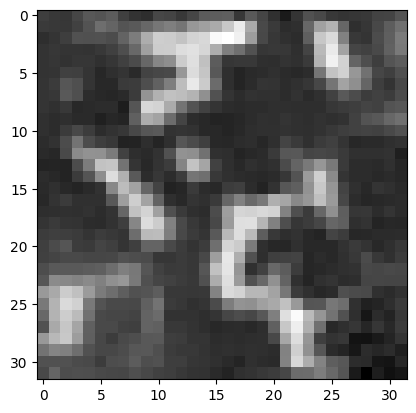

epoch 11 batch count 100 , avg loss is 0.016372309345752,             recon loss is 0.005840891390107572,             emb loss is 0.010531418016180396
epoch 11 batch count 200 , avg loss is 0.016329891392961145,             recon loss is 0.005828289140481502,             emb loss is 0.010501602236181497
epoch 11 batch count 300 , avg loss is 0.016416619426260392,             recon loss is 0.0058657746793081365,             emb loss is 0.010550844725221395
epoch 11 batch count 400 , avg loss is 0.016418400867842138,             recon loss is 0.005861307415179908,             emb loss is 0.010557093438692391
epoch 11 batch count 500 , avg loss is 0.016417993534356357,             recon loss is 0.005861862368881703,             emb loss is 0.010556131159886718
epoch 11 batch count 600 , avg loss is 0.01640412680649509,             recon loss is 0.005846133103283743,             emb loss is 0.010557993683032691
epoch 11 batch count 700 , avg loss is 0.016389296899682708,             recon 

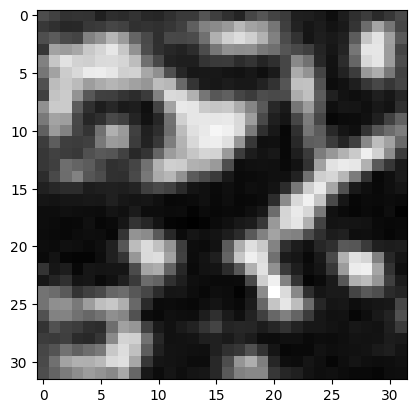

epoch 12 batch count 100 , avg loss is 0.016331258062273264,             recon loss is 0.0057190863462165,             emb loss is 0.0106121716927737
epoch 12 batch count 200 , avg loss is 0.016415247721597553,             recon loss is 0.005759108900092542,             emb loss is 0.010656138830818236
epoch 12 batch count 300 , avg loss is 0.016353948417430122,             recon loss is 0.005727155186856786,             emb loss is 0.01062679324299097
epoch 12 batch count 400 , avg loss is 0.01636053184280172,             recon loss is 0.005727548598079011,             emb loss is 0.010632983236573636
epoch 12 batch count 500 , avg loss is 0.016352944338694216,             recon loss is 0.005719429604709148,             emb loss is 0.010633514720946551
epoch 12 batch count 600 , avg loss is 0.01635738471833368,             recon loss is 0.005722456077734629,             emb loss is 0.010634928626629214
epoch 12 batch count 700 , avg loss is 0.016346083650631563,             recon loss

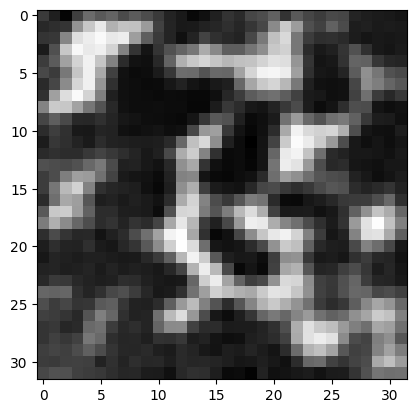

epoch 13 batch count 100 , avg loss is 0.01622284178622067,             recon loss is 0.005565069345757365,             emb loss is 0.010657772459089755
epoch 13 batch count 200 , avg loss is 0.016234691189602017,             recon loss is 0.005605666721239686,             emb loss is 0.010629024519585074
epoch 13 batch count 300 , avg loss is 0.016209424824143448,             recon loss is 0.005589004863674442,             emb loss is 0.010620420000826318
epoch 13 batch count 400 , avg loss is 0.0161760743544437,             recon loss is 0.0055774862144608054,             emb loss is 0.010598588169086725
epoch 13 batch count 500 , avg loss is 0.016165654404088854,             recon loss is 0.005575452934019267,             emb loss is 0.010590201469138265
epoch 13 batch count 600 , avg loss is 0.016120929569005966,             recon loss is 0.005558359438243012,             emb loss is 0.01056257012921075
epoch 13 batch count 700 , avg loss is 0.01610504281574062,             recon l

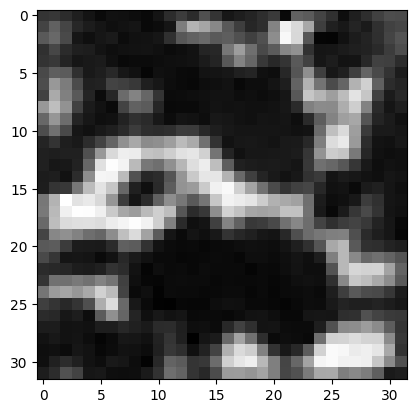

epoch 14 batch count 100 , avg loss is 0.01615379123017192,             recon loss is 0.005542769650928676,             emb loss is 0.010611021602526307
epoch 14 batch count 200 , avg loss is 0.0160330596473068,             recon loss is 0.005498705781064928,             emb loss is 0.010534353866241873
epoch 14 batch count 300 , avg loss is 0.016030489895492793,             recon loss is 0.005499154392940303,             emb loss is 0.010531335501000286
epoch 14 batch count 400 , avg loss is 0.01599893069593236,             recon loss is 0.005480958190746605,             emb loss is 0.010517972514498979
epoch 14 batch count 500 , avg loss is 0.01597957418486476,             recon loss is 0.0054783739829435945,             emb loss is 0.010501200214028358
epoch 14 batch count 600 , avg loss is 0.015972456401214002,             recon loss is 0.005474285576492548,             emb loss is 0.010498170832482476
epoch 14 batch count 700 , avg loss is 0.015979838942044546,             recon l

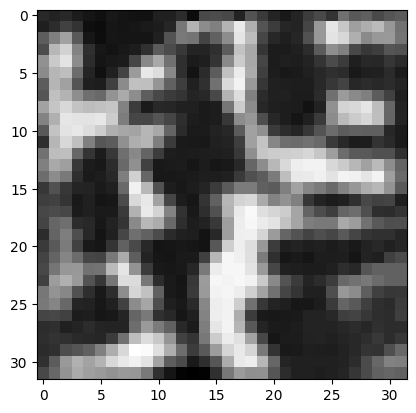

epoch 15 batch count 100 , avg loss is 0.016003542924299837,             recon loss is 0.005411991430446505,             emb loss is 0.010591551568359137
epoch 15 batch count 200 , avg loss is 0.01596235516946763,             recon loss is 0.005390039663761854,             emb loss is 0.010572315589524806
epoch 15 batch count 300 , avg loss is 0.015960756605491042,             recon loss is 0.005395963196642697,             emb loss is 0.010564793463175496
epoch 15 batch count 400 , avg loss is 0.015963009246625005,             recon loss is 0.005396000464679673,             emb loss is 0.010567008815705776
epoch 15 batch count 500 , avg loss is 0.015931878380477427,             recon loss is 0.005385881556198001,             emb loss is 0.010545996833592653
epoch 15 batch count 600 , avg loss is 0.01592757146960745,             recon loss is 0.0053870348197718465,             emb loss is 0.010540536654492219
epoch 15 batch count 700 , avg loss is 0.015912984253040382,             reco

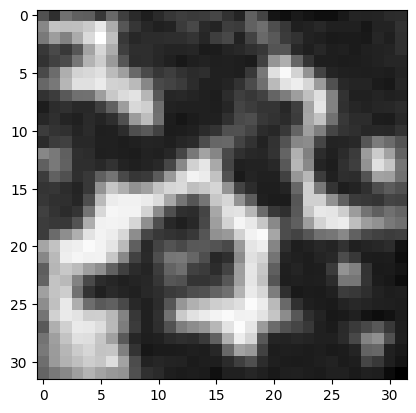

epoch 16 batch count 100 , avg loss is 0.01570364782586694,             recon loss is 0.005215874067507684,             emb loss is 0.010487773763015866
epoch 16 batch count 200 , avg loss is 0.01579506281763315,             recon loss is 0.00525848259916529,             emb loss is 0.010536580183543264
epoch 16 batch count 300 , avg loss is 0.01578530967546006,             recon loss is 0.005269789417895178,             emb loss is 0.010515520243595044
epoch 16 batch count 400 , avg loss is 0.015795037413481622,             recon loss is 0.005271321949549019,             emb loss is 0.010523715452291072
epoch 16 batch count 500 , avg loss is 0.01579408613592386,             recon loss is 0.005276524542830885,             emb loss is 0.01051756157912314
epoch 16 batch count 600 , avg loss is 0.015803636242635546,             recon loss is 0.005282792403983573,             emb loss is 0.010520843820025523
epoch 16 batch count 700 , avg loss is 0.015824254642107658,             recon los

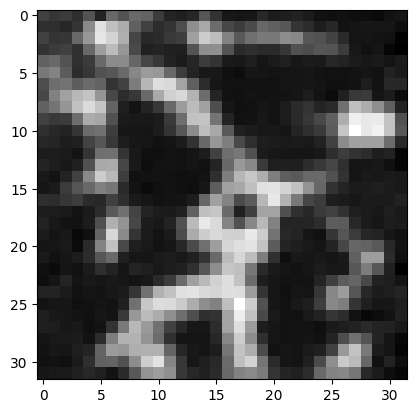

epoch 17 batch count 100 , avg loss is 0.015696670236065982,             recon loss is 0.005200891355052591,             emb loss is 0.01049577890895307
epoch 17 batch count 200 , avg loss is 0.015666861892677842,             recon loss is 0.005206323806196451,             emb loss is 0.010460538123734296
epoch 17 batch count 300 , avg loss is 0.015701094806815186,             recon loss is 0.005226556452301642,             emb loss is 0.010474538405736287
epoch 17 batch count 400 , avg loss is 0.01570636250311509,             recon loss is 0.005214947550557554,             emb loss is 0.010491414996795356
epoch 17 batch count 500 , avg loss is 0.015705017955973743,             recon loss is 0.005214613907039166,             emb loss is 0.010490404091775417
epoch 17 batch count 600 , avg loss is 0.015683868491711717,             recon loss is 0.005201185022791227,             emb loss is 0.01048268351238221
epoch 17 batch count 700 , avg loss is 0.01569003626970308,             recon l

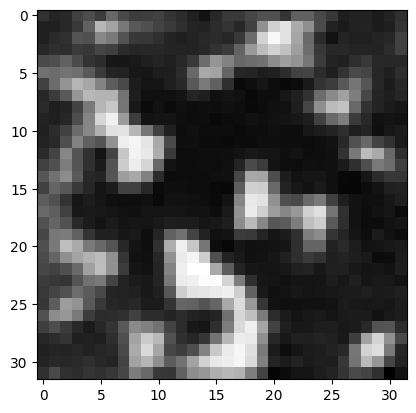

epoch 18 batch count 100 , avg loss is 0.015743312304839493,             recon loss is 0.005197274517267942,             emb loss is 0.010546037750318647
epoch 18 batch count 200 , avg loss is 0.01565323014743626,             recon loss is 0.00514731333591044,             emb loss is 0.010505916811525821
epoch 18 batch count 300 , avg loss is 0.015653822186092535,             recon loss is 0.00515900101667891,             emb loss is 0.010494821167861422
epoch 18 batch count 400 , avg loss is 0.015694080321118235,             recon loss is 0.005172275865916163,             emb loss is 0.01052180444356054
epoch 18 batch count 500 , avg loss is 0.0156689921207726,             recon loss is 0.0051680871564894915,             emb loss is 0.010500904951244592
epoch 18 batch count 600 , avg loss is 0.01567645259356747,             recon loss is 0.005167762767523527,             emb loss is 0.010508689818282922
epoch 18 batch count 700 , avg loss is 0.015679642156298673,             recon los

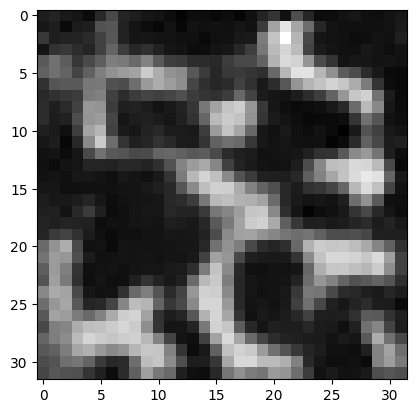

epoch 19 batch count 100 , avg loss is 0.015662621380761264,             recon loss is 0.005111648966558278,             emb loss is 0.010550972428172828
epoch 19 batch count 200 , avg loss is 0.015620522503741085,             recon loss is 0.0051054589031264185,             emb loss is 0.010515063619241118
epoch 19 batch count 300 , avg loss is 0.015631641587242485,             recon loss is 0.0051170884491875766,             emb loss is 0.01051455314271152
epoch 19 batch count 400 , avg loss is 0.015637215001042933,             recon loss is 0.0051174552668817345,             emb loss is 0.01051975974580273
epoch 19 batch count 500 , avg loss is 0.015633485563099386,             recon loss is 0.005112452067434788,             emb loss is 0.010521033506840468
epoch 19 batch count 600 , avg loss is 0.01562863869437327,             recon loss is 0.005113072871851424,             emb loss is 0.010515565825626254
epoch 19 batch count 700 , avg loss is 0.015635230888479523,             rec

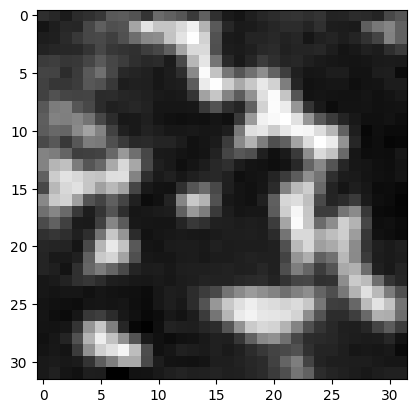

epoch 20 batch count 100 , avg loss is 0.015441699083894492,             recon loss is 0.0050313478009775285,             emb loss is 0.01041035121306777
epoch 20 batch count 200 , avg loss is 0.01551555453799665,             recon loss is 0.005040853472892195,             emb loss is 0.010474701044149697
epoch 20 batch count 300 , avg loss is 0.015539238769561052,             recon loss is 0.005061562031817933,             emb loss is 0.010477676717564464
epoch 20 batch count 400 , avg loss is 0.015557387792505324,             recon loss is 0.005064820374827832,             emb loss is 0.010492567389737814
epoch 20 batch count 500 , avg loss is 0.015556921318173409,             recon loss is 0.005058910056483,             emb loss is 0.010498011222109199
epoch 20 batch count 600 , avg loss is 0.015541478066394726,             recon loss is 0.0050566085540534305,             emb loss is 0.010484869486341874
epoch 20 batch count 700 , avg loss is 0.015555057420528361,             recon 

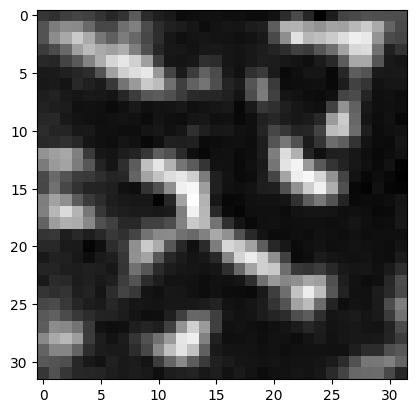

In [10]:
for epoch in range(20):
    train(epoch+1)
    generate_image(model.sample(1))

In [ ]:
def weights_init(m: nn.Module):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # have conv 
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)
            
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)
    
class GatedPixelCNN(nn.Module):
    
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=10):
        super().__init__()
        self.dim = dim

        
        